# Word Vectors from Scratch with Dummy and Small Corpus

## Packages

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import random

from collections import deque
import matplotlib.pyplot as plt

import json
import re

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# from nltk.corpus import brown
# nltk.download('brown')
# print(brown.words())

In [4]:
# print(brown.words())

In [5]:
# brown.raw()

## Importing our corpus and preprocessing

In [6]:
# # Example usage
# file_path = 'small_corpus.txt'
# with open(file_path, 'r', encoding='utf-8') as file:
#     text = file.read()

text =  """In our modern world there are many factors that place the wellbeing of the planet in jeopardy while some people have the opinion that environmental problems are just a natural occurrence, others believe that human beings have a huge impact on the environment regardless of your viewpoint take into consideration the following factors that place our environment as well as the planet Earth in danger
global warming or climate change is a major contributing factor to environmental damage because of global warming we have seen an increase in melting ice caps a rise in sea levels and the formation of new weather patterns these weather patterns have caused stronger storms droughts and flooding in places that they formerly did not occur
air pollution is primarily caused as a result of excessive and unregulated emissions of carbon dioxide into the air pollutants mostly emerge from the burning of fossil fuels in addition to chemicals toxic substances and improper waste disposal. Air pollutants are absorbed into the atmosphere, and they can cause smog, a combination of smoke and fog, in valleys as well as produce acidic precipitation in areas far away from the pollution source.
In many areas, people and local governments do not sustainably use their natural resources. Mining for natural gases, deforestation, and even improper use of water resources can have tremendous effects on the environment. While these strategies often attempt to boost local economies, their effects can lead to oil spills, interrupted animal habitats, and droughts.
Ultimately, the effects of the modern world on the environment can lead to many problems. Human beings need to consider the repercussions of their actions, trying to reduce, reuse, and recycle materials while establishing environmentally sustainable habits. If measures are not taken to protect the environment, we can potentially witness the extinction of more endangered species, worldwide pollution, and a completely uninhabitable planet.
"""

# text = brown

In [7]:
# words = list(brown.words())

# words = [
#     re.sub(r'[^a-zA-Z]', '', x).lower()
#     for x in words
#     if re.sub(r'[^a-zA-Z]', '', x).lower()
# ]

In [8]:
# words

In [9]:
def extract_unique_words(text):
    # # Lowercase and tokenize the text
    # text = text.lower()
    # words = word_tokenize(text)

    # # Remove punctuation
    # words = [word for word in words if word.isalpha()]

    # # Count the number of words and unique words
    # print("# of words in the text: ", len(words))

    # unique_words = sorted(set(words))
    # print("len of unqiue words in the text: ", len(unique_words))

    text = text.lower()

    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)
    words = text.split()
    # words = text
    unique_words = sorted(set(words))


    return unique_words

In [10]:
unique_words = extract_unique_words(text)

In [11]:
def generate_cbows(text, window_size):
    # Lowercase and tokenize the text
    # text = text.lower()
    # words = word_tokenize(text)

    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)
    words = text.split()
    # words = text

    # # Remove punctuation
    # words = [word for word in words if word.isalpha()]

    # Remove stop words
    # stop_words = set(stopwords.words('english'))
    # words = [word for word in words if word not in stop_words]

    # Create CBOW pairs with a given window size
    cbows = []
    for i, target_word in enumerate(words):
        context_words = words[max(0, i - window_size):i] + words[i + 1:i + window_size + 1]
        if len(context_words) == window_size * 2:
            cbows.append((context_words, target_word))
    return cbows

In [12]:
# Create cbows
cbows = generate_cbows(text, window_size=3)

# Display the results
for context_words, target_word in cbows[:3]:
    print(f'Context Words: {context_words}, Target Word: {target_word}')

Context Words: ['in', 'our', 'modern', 'there', 'are', 'many'], Target Word: world
Context Words: ['our', 'modern', 'world', 'are', 'many', 'factors'], Target Word: there
Context Words: ['modern', 'world', 'there', 'many', 'factors', 'that'], Target Word: are


In [13]:
len(cbows)

300

In [18]:
import numpy as np


def one_hot_encoding(unique_words):
    enc_size = len(unique_words)
    encds = np.zeros((enc_size, enc_size))
    dict_enc = {}
    for i, word in enumerate(unique_words):
        encds[i][i] = 1
        dict_enc[word] = torch.tensor(encds[i], dtype=torch.float32)



    return dict_enc


In [19]:
one_hot_encodings = one_hot_encoding(unique_words)

In [20]:
# Convert CBOW pairs to vector pairs
cbow_vector_pairs = [([one_hot_encodings[word] for word in context_words], one_hot_encodings[target_word]) for context_words, target_word in cbows]

In [22]:
cbow_vector_pairs[0][0] # contains the 6 context word one-hot encoded vectors

[tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.])]

In [23]:
from tqdm import tqdm

# Sum the context vectors to get a single context vector
cbow_vector_pairs = [(torch.sum(torch.stack(context_vectors), dim=0), target_vector) for context_vectors, target_vector in tqdm(cbow_vector_pairs)]

100%|██████████| 300/300 [00:00<00:00, 8229.40it/s]


In [27]:
cbow_vector_pairs[0]

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0

## Converting the dataset to PyTorch Dataset

In [28]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.inputs = [item[0] for item in data]
        self.outputs = [item[1] for item in data]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_sample = self.inputs[idx]
        output_sample = self.outputs[idx]
        return input_sample, output_sample

In [30]:
# Shuffle pairs before training
cbow_vector_pairs = random.sample(cbow_vector_pairs, len(cbow_vector_pairs))

# Train and Val split
split_index = int(len(cbow_vector_pairs) * 0.90)

# Split the data into training and test sets
train_dataset = CustomDataset(cbow_vector_pairs[:split_index])
test_dataset = CustomDataset(cbow_vector_pairs[split_index:])

# Set batch size
batch_size = 8  # You can adjust this based on your requirements

# Create DataLoader for training and test sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Naive Word2Vec Model

In [31]:
class NaiveWord2Vec(nn.Module):

    def __init__(self, VOCAB_SIZE, VECTOR_DIM) -> None:
        super().__init__()

        self.vocab_size = VOCAB_SIZE
        self.vector_dim = VECTOR_DIM
        self.W1 = nn.Parameter(data=torch.randn(self.vocab_size, self.vector_dim), requires_grad=True) # Word Vectors
        self.W2 = nn.Parameter(data=torch.randn(self.vector_dim, self.vocab_size), requires_grad=True)

    def forward(self, X) -> torch.tensor:
        X = X @ self.W1
        X = X @ self.W2

        return X

In [32]:
VOCAB_SIZE = len(unique_words)
VECTOR_DIM = 2

## Training the model

In [33]:
model = NaiveWord2Vec(VOCAB_SIZE, VECTOR_DIM)

In [34]:
def train_model(model, train_dataloader, validation_dataloader, epochs, learning_rate, verbose=False):

    # Create the loss function
    loss_fn = nn.CrossEntropyLoss()
    # Create the optimizer object
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

    # Log the loss values
    train_set_loss_log = []
    validation_set_loss_log = []

    for epoch in range(epochs):
        if verbose: print("Epoch: ", epoch)
        # Training mode on
        model.train()
        total_train_loss = 0.0
        num_train_batches = 0

        for inputs_batch, outputs_batch in train_dataloader:

            y_train_logits = model(inputs_batch)
            train_loss = loss_fn(y_train_logits, outputs_batch)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            total_train_loss += train_loss.item()
            num_train_batches += 1

        # Calculate average training loss for the epoch
        average_train_loss = total_train_loss / num_train_batches
        train_set_loss_log.append(average_train_loss)

        # Eval mode on
        model.eval()
        total_validation_loss = 0.0
        num_validation_batches = 0

        with torch.inference_mode():
            for inputs_batch, outputs_batch in validation_dataloader:
                # Evaluate the validation loss
                y_val_logits = model(inputs_batch)
                validation_loss = loss_fn(y_val_logits, outputs_batch)

                total_validation_loss += validation_loss.item()
                num_validation_batches += 1

        # Calculate average validation loss for the epoch
        average_validation_loss = total_validation_loss / num_validation_batches
        validation_set_loss_log.append(average_validation_loss)

        if verbose: print("Train Loss: ", average_train_loss, "|||", "Validation Loss: ", average_validation_loss)


    return model, train_set_loss_log, validation_set_loss_log

In [35]:
model, train_set_loss_log, validation_set_loss_log = train_model(model, train_dataloader, validation_dataloader,
                                                                 epochs=100, learning_rate=0.01, verbose=True)

Epoch:  0
Train Loss:  8.682458302553963 ||| Validation Loss:  8.437082290649414
Epoch:  1
Train Loss:  7.327306733411901 ||| Validation Loss:  7.448974013328552
Epoch:  2
Train Loss:  6.540071431328268 ||| Validation Loss:  6.862943649291992
Epoch:  3
Train Loss:  5.983536636128145 ||| Validation Loss:  6.45382022857666
Epoch:  4
Train Loss:  5.614647654926076 ||| Validation Loss:  6.195752501487732
Epoch:  5
Train Loss:  5.326433574452119 ||| Validation Loss:  6.012636423110962
Epoch:  6
Train Loss:  5.120544770184686 ||| Validation Loss:  5.915566802024841
Epoch:  7
Train Loss:  4.95833225811229 ||| Validation Loss:  5.83186936378479
Epoch:  8
Train Loss:  4.8295943176045135 ||| Validation Loss:  5.763653993606567
Epoch:  9
Train Loss:  4.7276740074157715 ||| Validation Loss:  5.747674465179443
Epoch:  10
Train Loss:  4.621452163247501 ||| Validation Loss:  5.7370604276657104
Epoch:  11
Train Loss:  4.538711926516364 ||| Validation Loss:  5.734867811203003
Epoch:  12
Train Loss:  4.

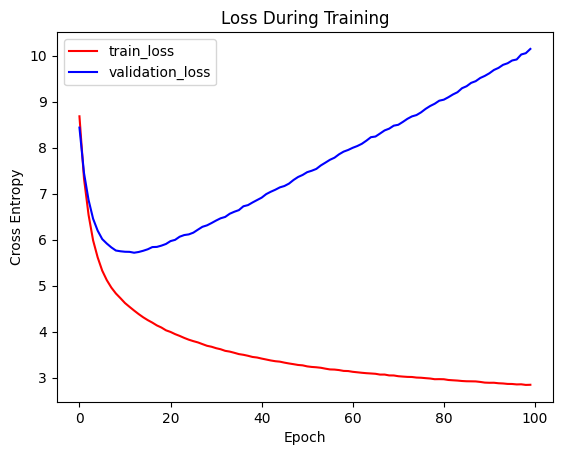

In [36]:
plt.plot(train_set_loss_log, color='red', label='train_loss')
plt.plot(validation_set_loss_log, color='blue', label='validation_loss')

plt.title("Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy")
plt.legend()
plt.show()

In [40]:
model = NaiveWord2Vec(VOCAB_SIZE, VECTOR_DIM)

In [41]:
model, train_set_loss_log, validation_set_loss_log = train_model(model, train_dataloader, validation_dataloader,
                                                                 epochs=10, learning_rate=0.01, verbose=True)

Epoch:  0
Train Loss:  9.023288334117217 ||| Validation Loss:  8.078972578048706
Epoch:  1
Train Loss:  7.671759843826294 ||| Validation Loss:  7.248160004615784
Epoch:  2
Train Loss:  6.813560850480023 ||| Validation Loss:  6.723310708999634
Epoch:  3
Train Loss:  6.246565818786621 ||| Validation Loss:  6.399610877037048
Epoch:  4
Train Loss:  5.823294317021089 ||| Validation Loss:  6.150528430938721
Epoch:  5
Train Loss:  5.538502903545604 ||| Validation Loss:  5.997895002365112
Epoch:  6
Train Loss:  5.316581080941593 ||| Validation Loss:  5.864629030227661
Epoch:  7
Train Loss:  5.129541088553036 ||| Validation Loss:  5.765830159187317
Epoch:  8
Train Loss:  4.9918984805836395 ||| Validation Loss:  5.712756276130676
Epoch:  9
Train Loss:  4.881250591839061 ||| Validation Loss:  5.652229070663452


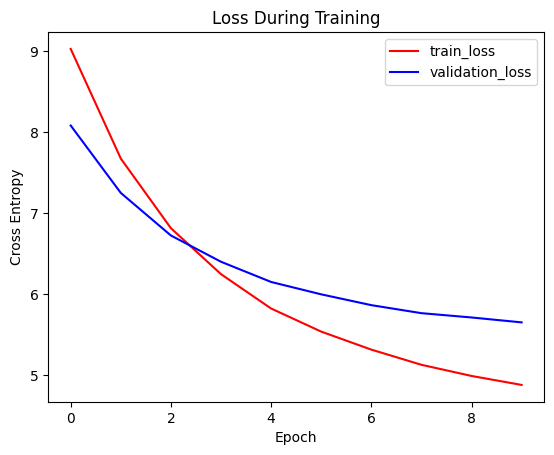

In [42]:
plt.plot(train_set_loss_log, color='red', label='train_loss')
plt.plot(validation_set_loss_log, color='blue', label='validation_loss')

plt.title("Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy")
plt.legend()
plt.show()

In [43]:
# Word Vectors
params = list(model.parameters())
word_vectors = params[0].detach()

In [44]:
# Create a dictionary with the same order mapping
word_dict = {word: vector for word, vector in zip(unique_words, word_vectors)}

## Evaluating the Word Vectors

In [45]:
def cosine_similarity(v1, v2):
    return (v1 @ v2) / (torch.norm(v1) * torch.norm(v2))

def most_similar(word, word_dict, top_k=5):
    if word not in word_dict:
        raise ValueError(f"{word} not found in the word dictionary.")

    query_vector = word_dict[word]

    # Calculate cosine similarity with all other words in the dictionary
    similarities = {}
    for other_word, other_vector in word_dict.items():
        if other_word != word:
            similarity = cosine_similarity(query_vector, other_vector)
            similarities[other_word] = similarity

    # Sort the words by similarity in descending order
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

    # Get the top-k most similar words
    top_similar_words = sorted_similarities[:top_k]

    return top_similar_words

In [46]:
word_dict

{'a': tensor([-0.6696, -0.9820]),
 'absorbed': tensor([-1.7744, -0.0201]),
 'acidic': tensor([-1.7696, -1.2957]),
 'actions': tensor([-1.0338,  0.4523]),
 'addition': tensor([ 0.0763, -0.0575]),
 'air': tensor([-0.4759,  0.3921]),
 'an': tensor([ 0.4629, -2.0448]),
 'and': tensor([-0.6347,  0.3520]),
 'animal': tensor([0.3100, 0.2315]),
 'are': tensor([0.6426, 0.3458]),
 'areas': tensor([-0.3427, -0.3124]),
 'as': tensor([-1.3135, -0.1130]),
 'atmosphere': tensor([ 0.4602, -1.0137]),
 'attempt': tensor([ 0.7262, -0.1754]),
 'away': tensor([-0.2158, -0.1212]),
 'because': tensor([ 0.2625, -0.7301]),
 'beings': tensor([0.3703, 0.0765]),
 'believe': tensor([ 0.0685, -1.0567]),
 'boost': tensor([-0.0750,  1.3678]),
 'burning': tensor([ 0.1846, -0.1915]),
 'can': tensor([ 0.3256, -0.0398]),
 'caps': tensor([ 0.0097, -0.9339]),
 'carbon': tensor([ 0.1554, -0.3116]),
 'cause': tensor([-2.1821, -0.0788]),
 'caused': tensor([0.3178, 0.9394]),
 'change': tensor([-2.2014, -1.4084]),
 'chemicals':

In [48]:
word_dict['sea']

tensor([ 0.8965, -0.0327])

In [49]:
most_similar('sea', word_dict)

[('climate', tensor(0.9999)),
 ('sustainable', tensor(0.9994)),
 ('smoke', tensor(0.9967)),
 ('can', tensor(0.9964)),
 ('modern', tensor(0.9901))]

In [51]:
most_similar('toxic', word_dict)

[('warming', tensor(1.0000)),
 ('flooding', tensor(0.9999)),
 ('potentially', tensor(0.9998)),
 ('local', tensor(0.9976)),
 ('droughtsultimately', tensor(0.9976))]

In [52]:
most_similar('water', word_dict)

[('substances', tensor(1.0000)),
 ('pollution', tensor(0.9995)),
 ('primarily', tensor(0.9993)),
 ('into', tensor(0.9985)),
 ('addition', tensor(0.9959))]

In [53]:
cosine_similarity(word_dict['water'], word_dict['sea'])

tensor(0.8684)

In [55]:
cosine_similarity(word_dict['water'], word_dict['believe'])

tensor(0.5811)

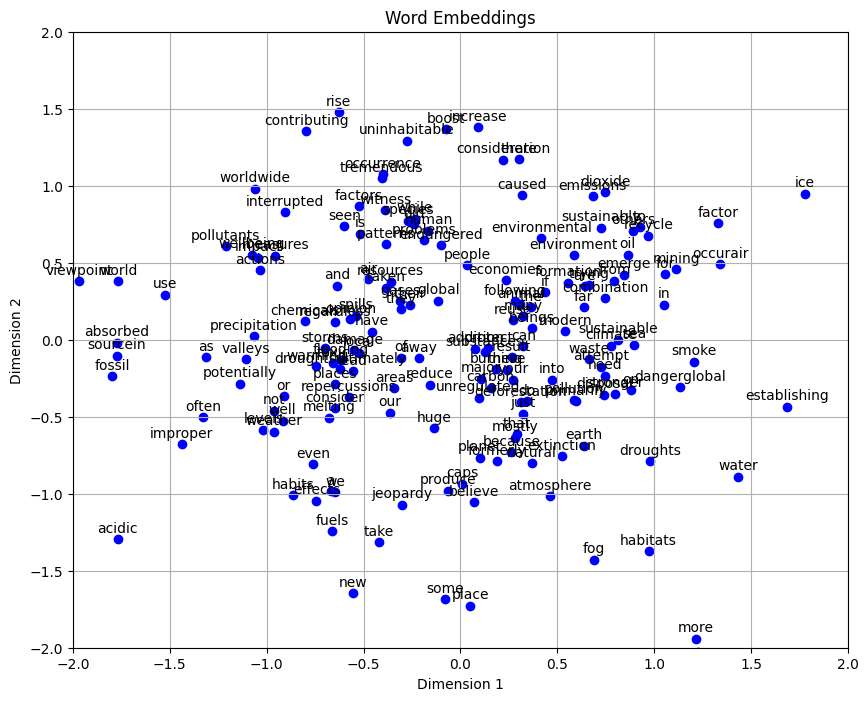

In [56]:
x_coords, y_coords = zip(*[word_dict[word].numpy() for word in list(word_dict.keys())])

plt.figure(figsize=(10, 8))
plt.scatter(x_coords, y_coords, marker='o', color='blue')

for i, word in enumerate(list(word_dict.keys())):
    plt.annotate(word, (x_coords[i], y_coords[i]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.title('Word Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()

`Need to try bigger corpus`

## Export Word Vectors

In [57]:
# Specify the file path where you want to save the JSON file
file_path = 'pretrained_word_vectors.json'

# Convert torch.Tensor objects to lists
word_vec_for_export = word_dict.copy()
for key, value in word_vec_for_export.items():
    if isinstance(value, torch.Tensor):
        word_vec_for_export[key] = value.tolist()

# Use json.dump to write the modified dictionary to a JSON file
with open(file_path, 'w') as json_file:
    json.dump(word_vec_for_export, json_file, indent=2)

print(f'Dictionary has been exported to {file_path}')

Dictionary has been exported to pretrained_word_vectors.json
